# Полносвязная нейросеть на numpy

In [1]:
from layers import ReLU, Tanh, Sigmoid, Dense, LogSoftmax
from loss import NLL, grad_NLL
from numericgrad import num_grad

import numpy as np
from scipy.optimize import minimize

## Проверка правильности реализованных градиентов

### NLL loss

Сравним аналитический и численный градиенты лосса NLL

In [2]:
n = 2   # batch size
d = 10  # units num
target = np.random.choice(d, size=n)
batch = np.random.uniform(-1, 1, n*d).reshape((n, d))

# analytical formula
lsm = LogSoftmax(d)
acts = lsm.forward(batch)
loss = NLL(acts, target)
grads = lsm.backward(grad_NLL(acts, target))[0]

# numerical estimation
num_grads = num_grad(lambda x: NLL(lsm.forward(x), target), batch)

assert np.allclose(grads, num_grads, rtol=1e-3, atol=0)

### ReLU

Сравним аналитический и численный градиенты функции
$$ f(y) = \sum_i y_i, \quad y = ReLU(x) $$
по входу функции ReLU. На вход `relu.backward()` нужно подать
$$
\frac{\partial f}{\partial y}=\mathbb{1}.
$$

In [3]:
n = 10  # batch size
d = 12  # input size
relu = ReLU()
points = np.linspace(-1, 1, n * d).reshape((n,d))

# analytical formula
f = relu.forward(points).sum(axis=1)
grads = relu.backward(np.ones((n, d)))

# numerical estimation
num_grads = num_grad(lambda x: relu.forward(x).sum(), points)

assert np.allclose(grads[0], num_grads, rtol=1e-3, atol=0)

### Linear Layer

Сравним аналитический и численный градиенты лосса NLL по входу полносвязного слоя 

In [4]:
n = 10  # batch size
d = 12  # input size
m = 32  # output size
linear = Dense(d, m)
points = np.linspace(-1, 1, n * d).reshape((n, d))

# analytical formula
f = linear.forward(points).sum(axis=1)
grads = linear.backward(np.ones((n, m)))

# numerical estimation
num_grads = num_grad(lambda x: linear.forward(x).sum(), points)

assert np.allclose(grads[0], num_grads, rtol=1e-3, atol=0)

## Обучение сети

### Загрузка данных

In [5]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
X, y = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_train.shape, X_test.shape

((1347, 64), (450, 64))

### Утилиты для обучения

In [7]:
def make_network(input_size, hidden_layers_size, output_size, n_layers=3, activation_class=ReLU):
    network = []

    for layer_idx in range(n_layers):
        # Compute sizes of current linear layer
        layer_in = input_size if layer_idx == 0 else hidden_layers_size
        layer_out = output_size if layer_idx == n_layers - 1 else hidden_layers_size
        
        # Add linear layer to the network
        network.append(Dense(layer_in, layer_out))

        # Add activation after each layer except the last one
        if layer_idx != n_layers - 1:
            network.append(activation_class())

    # Add LogSoftmax layer to the network
    network.append(LogSoftmax(output_size))

    return network

In [8]:
def forward(network, X):
    """
    Perform forward pass through the network.
    
    network: list of layers
    X: raw data, shape (batch, features_num)

    output: shape (batch, out_features_num)
    """
    x = X.copy()
    for layer in network:
      x = layer.forward(x)
    return x

In [9]:
def predict(network, X):
    """
    Returns predictions for each object in X.
    
    network: list of layers
    X: raw data, shape (batch, features_num)

    output: array of classes, each from 0 to 9
            shape (batch,)
    """
    return forward(network, X).argmax(axis=1)

In [10]:
def get_weights(network):
    weights = []
    for layer in network:
        for param in layer.params:
            weights += param.ravel().tolist()
    return np.array(weights)


def set_weights(weights, network):
    i = 0
    for layer in network:
        for param in layer.params:
            l = param.size
            param[:] = weights[i:i+l].reshape(param.shape)
            i += l

In [11]:
def compute_loss_grad(weights, args):
    """
    takes current weights and computes cross-entropy and gradients
    weights shape: [num_parameters]
    output 1: loss (scalar)
    output 2: gradint w.r.t. weights, shape: [num_parameters]
    """
    network, X, y = args

    # forward pass
    set_weights(weights, network)
    y_pred = forward(network, X)
    
    # compute loss
    loss = NLL(y_pred, y)
    
    # compute loss grad
    grad_output = grad_NLL(y_pred, y)

    # backward pass
    grads = []
    for layer in network[::-1]:
      grad_output, grad_params = layer.backward(grad_output)
      grads = grad_params + grads

    # to numpy
    grads = np.concatenate(grads)

    return loss, grads

In [12]:
class Callback:
    def __init__(self, network, X_train, y_train, X_test, y_test, print=False):
        self.network = network
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.print = print
        self.train_acc = []
        self.test_acc = []
        
    def call(self, weights):
        """
        Computes quality on train and test set with given weights
        and saves to self.train_acc and self.test_acc.
        If self.print is True, also prints these 2 values
        """
        set_weights(weights, self.network)
        train_pred = predict(self.network, self.X_train)
        test_pred = predict(self.network, self.X_test)
        acc1 = (train_pred == self.y_train).mean()
        acc2 = (test_pred == self.y_test).mean()
        self.train_acc.append(acc1)
        self.test_acc.append(acc2)
        if self.print:
          print(f'train acc: {acc1:.3f}, test acc: {acc2:.3f}')
        if acc2 > max(self.test_acc):
          self.weights = weights.copy()

### Обучение

In [13]:
input_size = X_train.shape[1]
hidden_layers_size = 32
output_size = 10

network = make_network(input_size, hidden_layers_size, output_size, 3, ReLU)
network

[Dense(64, 32), Relu(), Dense(32, 32), Relu(), Dense(32, 10), LogSoftmax(10)]

In [14]:
cb = Callback(network, X_train, y_train, X_test, y_test, print=True)

res = minimize(
    compute_loss_grad, get_weights(network),
    args=[network, X_train, y_train],
    method="L-BFGS-B",
    jac=True,
    callback=cb.call
)

train acc: 0.106, test acc: 0.084
train acc: 0.113, test acc: 0.093
train acc: 0.116, test acc: 0.093
train acc: 0.151, test acc: 0.127
train acc: 0.352, test acc: 0.331
train acc: 0.351, test acc: 0.358
train acc: 0.472, test acc: 0.476
train acc: 0.441, test acc: 0.431
train acc: 0.578, test acc: 0.551
train acc: 0.572, test acc: 0.571
train acc: 0.683, test acc: 0.642
train acc: 0.719, test acc: 0.687
train acc: 0.745, test acc: 0.711
train acc: 0.786, test acc: 0.756
train acc: 0.783, test acc: 0.742
train acc: 0.800, test acc: 0.784
train acc: 0.836, test acc: 0.811
train acc: 0.854, test acc: 0.833
train acc: 0.872, test acc: 0.869
train acc: 0.875, test acc: 0.864
train acc: 0.884, test acc: 0.880
train acc: 0.889, test acc: 0.893
train acc: 0.907, test acc: 0.900
train acc: 0.922, test acc: 0.907
train acc: 0.931, test acc: 0.909
train acc: 0.938, test acc: 0.916
train acc: 0.945, test acc: 0.927
train acc: 0.950, test acc: 0.933
train acc: 0.953, test acc: 0.933
train acc: 0.9

Результаты обучения:

In [15]:
res

      fun: 5.486432177332547e-07
 hess_inv: <3466x3466 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00000000e+00, -1.85217990e-08, -2.23786698e-07, ...,
        4.19404816e-08, -1.00136642e-07, -4.78528109e-08])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 101
      nit: 89
     njev: 101
   status: 0
  success: True
        x: array([-1.63268799e-03,  1.26299985e-02, -1.03791955e-02, ...,
       -9.61990132e-01, -1.92585200e+00, -4.21117316e-01])

NLL (Train / Test)	: 0.000 / 1.071
Accuracy (Train / Test)	: 1.000 / 0.956


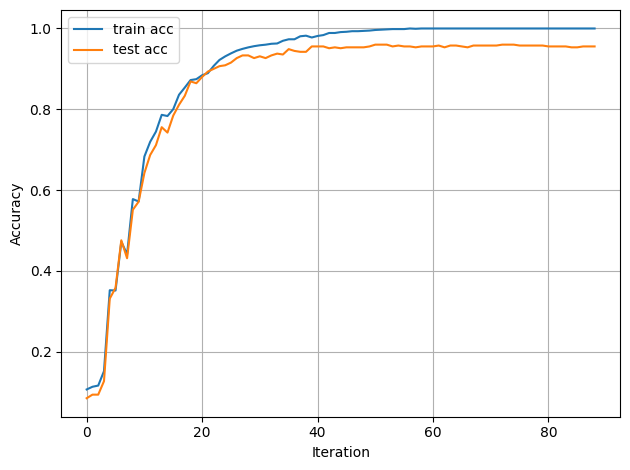

In [16]:
set_weights(res['x'], network)
train_pred = forward(network, X_train)
test_pred = forward(network, X_test)
nll_train = NLL(train_pred, y_train)
nll_test = NLL(test_pred, y_test)
print(f'NLL (Train / Test)\t: {nll_train:.3f} / {nll_test:.3f}')
acc_train = (train_pred.argmax(axis=1) == y_train).mean()
acc_test = (test_pred.argmax(axis=1) == y_test).mean()
print(f'Accuracy (Train / Test)\t: {acc_train:.3f} / {acc_test:.3f}')

plt.plot(cb.train_acc, label="train acc")
plt.plot(cb.test_acc, label="test acc")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

## Эксперименты

In [17]:
def score(network, res):
  set_weights(res['x'], network)
  train_pred = predict(network, X_train)
  test_pred = predict(network, X_test)
  acc_train = (train_pred == y_train).mean()
  acc_test = (test_pred == y_test).mean()
  return acc_train, acc_test

### Число слоёв

Посмотрим, какое качество достигает сеть в зависимости от числа слоёв.

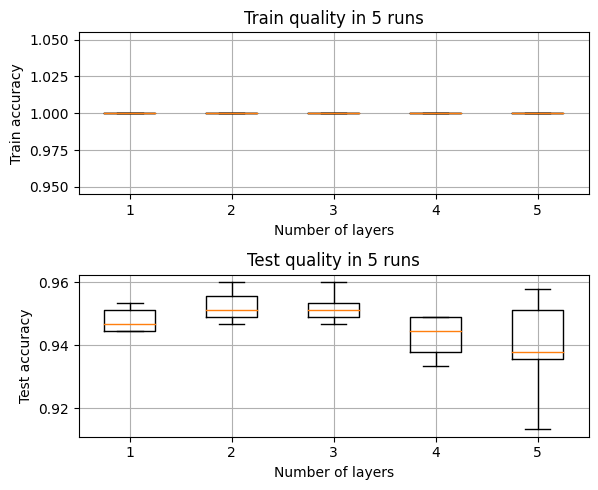

In [18]:
# configs
n_layers = 5
n_tries = 5
accs_train = np.zeros((n_layers, n_tries))
accs_test = np.zeros((n_layers, n_tries))

input_size = X_train.shape[1]
hidden_layers_size = 32
output_size = 10

# experiments
for i in range(n_layers):
  for j in range(n_tries):
    network = make_network(input_size, hidden_layers_size, output_size, i+1, ReLU)
    res = minimize(
        compute_loss_grad, get_weights(network),
        args=[network, X_train, y_train],
        method="L-BFGS-B", 
        jac=True,
    )
    accs_train[i,j], accs_test[i,j] = score(network, res)

# visualization
fig, axes = plt.subplots(2, 1, figsize=(6, 5))

axes[0].boxplot(accs_train.T, showfliers=False)
axes[1].boxplot(accs_test.T, showfliers=False)

axes[0].set_xlabel("Number of layers")
axes[1].set_xlabel("Number of layers")

axes[0].set_ylabel("Train accuracy")
axes[1].set_ylabel("Test accuracy")

axes[0].set_title("Train quality in 5 runs")
axes[1].set_title("Test quality in 5 runs")

axes[0].grid(True)
axes[1].grid(True)

fig.tight_layout()
plt.show()

Мысли:
- на обучении качество всегда 100-процентное
- на тесте качество унимодально по числу слоёв: максимум достигается при трех слоях
- результаты всегда одинаково неустойчивы при 2, 4, 5 слоях
- линейная модель дает качество хуже

### Инициализация весов

Посмотрим, как инициализация весов влияет скорость и качество обучения.

In [19]:
def initialize_network(network, initialization):
    for layer in network:
        if isinstance(layer, Dense):
            output_units, input_units = layer.weights.shape
            if initialization == 'Kaiming':
                layer.weights = np.random.normal(
                    loc=0,
                    scale=np.sqrt(2/input_units),
                    size=(output_units, input_units))
            elif initialization == 'Xavier':
                layer.weights = np.random.uniform(
                    low=-1/np.sqrt(input_units),
                    high=1/np.sqrt(input_units),
                    size=(output_units, input_units))
                pass
            else:
                # In case `initialization` represents a standard deviation
                layer.weights = np.random.randn(output_units, input_units) * initialization
            layer.biases = np.zeros_like(layer.biases)
            
            layer.params = [layer.weights, layer.biases]

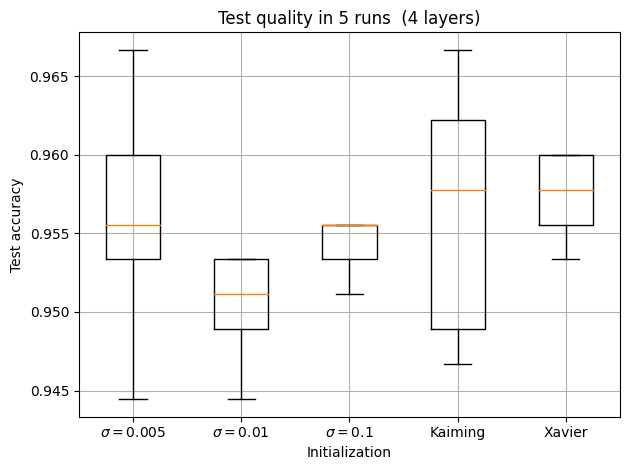

In [20]:
# config
init_vars = [5e-3, 1e-2, 1e-1, 'Kaiming', 'Xavier']

n_inits = 5
n_tries = 5
accs_train = np.zeros((n_inits, n_tries))
accs_test = np.zeros((n_inits, n_tries))

input_size = X_train.shape[1]
hidden_layers_size = 32
output_size = 10

# experiments
for i, init in enumerate(init_vars):
  for j in range(n_tries):
    network = make_network(input_size, hidden_layers_size, output_size, 4, ReLU)
    initialize_network(network, init)
    res = minimize(
        compute_loss_grad, get_weights(network),
        args=[network, X_train, y_train],
        method="L-BFGS-B", 
        jac=True,
    )
    accs_train[i,j], accs_test[i,j] = score(network, res)

# visualization
init_vars_for_plot = [(x if isinstance(x, str) else fr"$\sigma = {x}$") for x in init_vars]

plt.boxplot(accs_test.T, labels=init_vars_for_plot, showfliers=False)

plt.title("Test quality in 5 runs  (4 layers)")
plt.xlabel("Initialization")
plt.ylabel("Test accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()

### Функции активации

Посмотрим, как выбор функции активации влияет на качество

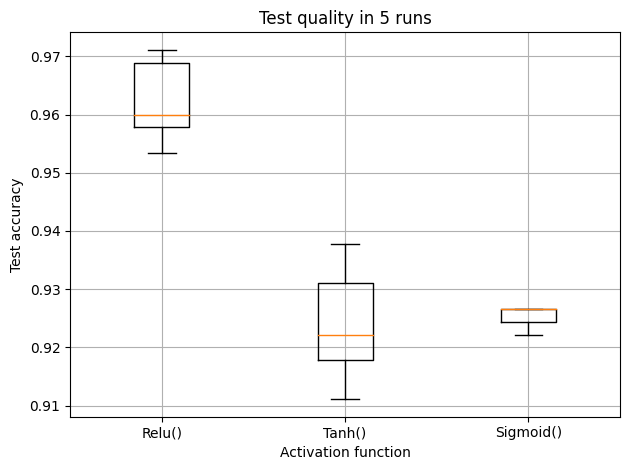

In [21]:
# config
act_func_vars = [ReLU, Tanh, Sigmoid]
init_for_act_funcs = ['Kaiming', 'Xavier', 'Xavier']

n_acts = len(act_func_vars)
n_tries = 5
accs_train = np.zeros((n_acts, n_tries))
accs_test = np.zeros((n_acts, n_tries))

input_size = X_train.shape[1]
hidden_layers_size = 32
output_size = 10

# experiments
for i, act in enumerate(act_func_vars):
  for j in range(n_tries):
    network = make_network(input_size, hidden_layers_size, output_size, 3, act)
    initialize_network(network, init_for_act_funcs[i])
    res = minimize(
        compute_loss_grad, get_weights(network),
        args=[network, X_train, y_train],
        method="L-BFGS-B", 
        jac=True,
    )
    accs_train[i,j], accs_test[i,j] = score(network, res)

# visualization
plt.boxplot(accs_test.T,
           labels=[act.__repr__(act) for act in act_func_vars],
           showfliers=False)

plt.title("Test quality in 5 runs")
plt.xlabel("Activation function")
plt.ylabel("Test accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()